In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os

import analysis    #analysis.py in lqcd/pion_mass directory

## Read in correlation functions

In [2]:
# cfgbase = 'su3_24_48_b6p10050'
cfgbase = 'cl3_16_48_b6p1_m0p2450'
job_num = 5741
base = './output/' + cfgbase + '_' + str(job_num)
save_graphs = False

C = analysis.read_h5(base)[0]    # get 0 momentum slice

## Bootstrap data

In [3]:
num_configs = C.shape[0]
n_t = C.shape[1]
samples = analysis.bootstrap(C)

## Compute correlation function and effective mass

In [4]:
# Compute ensemble average of each correlation function
ensemble_avg = np.mean(samples, axis = 1)
μ_C = np.abs(np.mean(ensemble_avg, axis = 0))
σ_C = np.abs(np.std(ensemble_avg, axis = 0))

In [5]:
# Compute effective mass and cosh corrected effective mass.
μ_m_eff, σ_m_eff = analysis.get_effective_mass(ensemble_avg)
μ_cosh, σ_cosh = analysis.get_cosh_effective_mass(ensemble_avg)

<IPython.core.display.Javascript object>


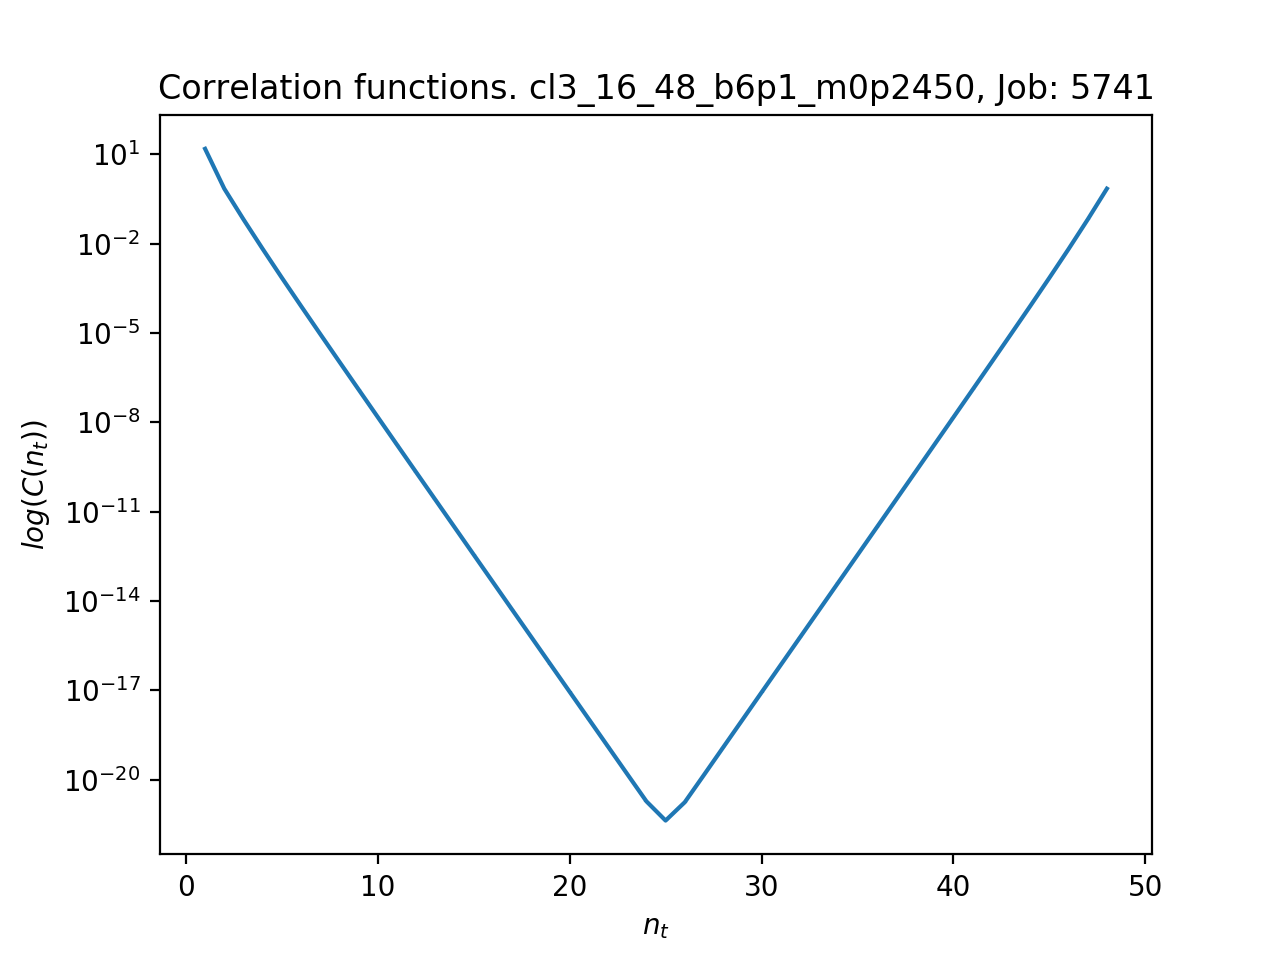

Text(0, 0.5, '$log(C(n_t))$')

In [6]:
plt.figure()
plt.errorbar(range(1, n_t + 1), μ_C, yerr = σ_C)
plt.yscale('log')
plt.title('Correlation functions. ' + cfgbase + ', Job: ' + str(job_num))
plt.xlabel('$n_t$')
plt.ylabel('$log(C(n_t))$')

In [7]:
if save_graphs:
    plt.savefig('/Users/theoares/lqcd/pion_mass/output/graphs/1_22_2020/' + cfgbase + '/twopt' + str(job_num) + '.png')

<IPython.core.display.Javascript object>


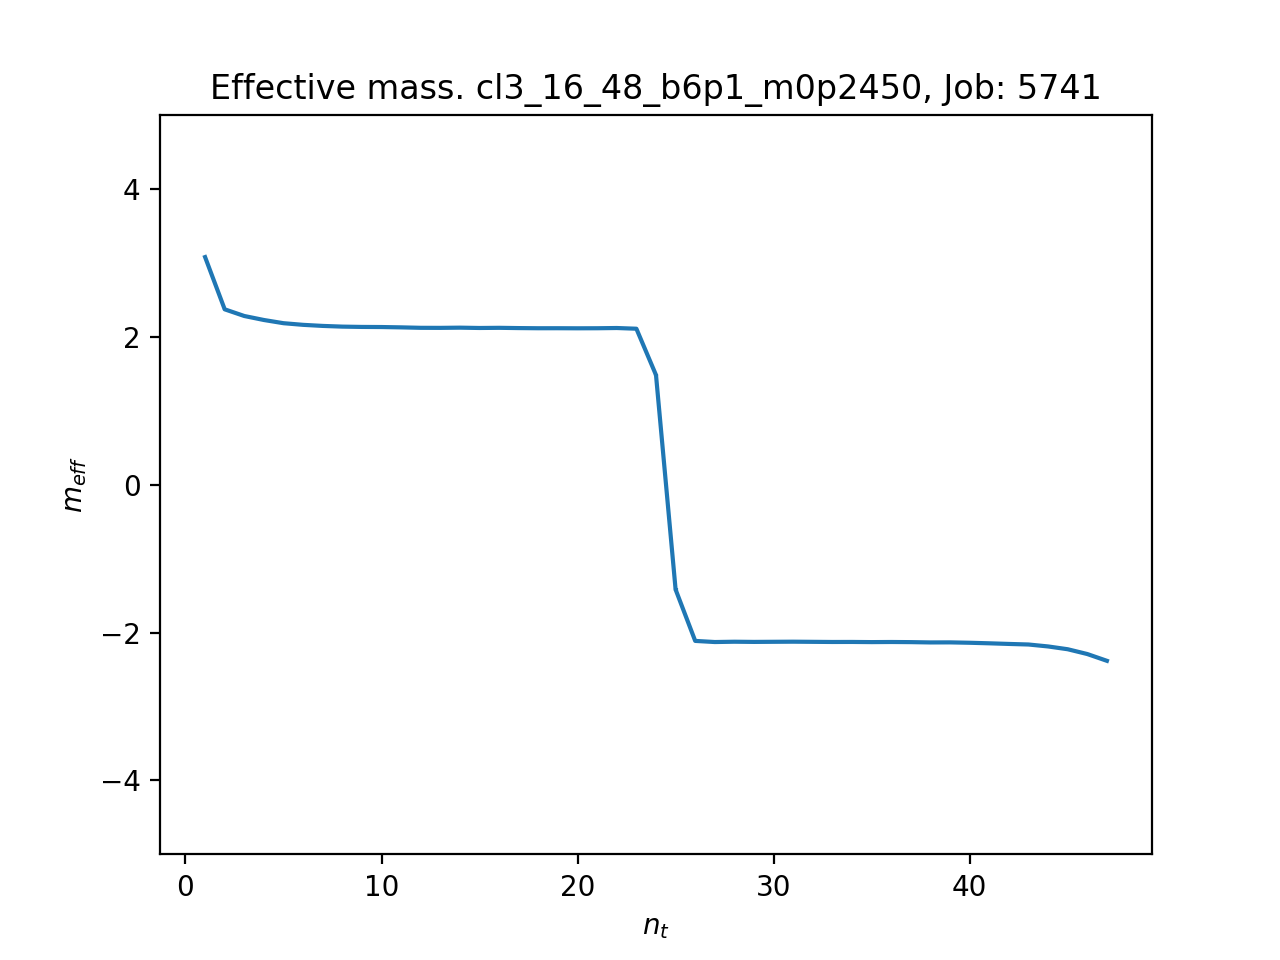

Text(0, 0.5, '$m_{eff}$')

In [8]:
plt.figure()
plt.errorbar(range(1, n_t), μ_m_eff, yerr = σ_m_eff)
plt.title('Effective mass. ' + cfgbase + ', Job: ' + str(job_num))
plt.ylim((-5, 5))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')

In [9]:
if save_graphs:
    plt.savefig('/Users/theoares/lqcd/pion_mass/output/graphs/1_22_2020/' + cfgbase + '/meff_' + str(job_num) + '.png')

<IPython.core.display.Javascript object>


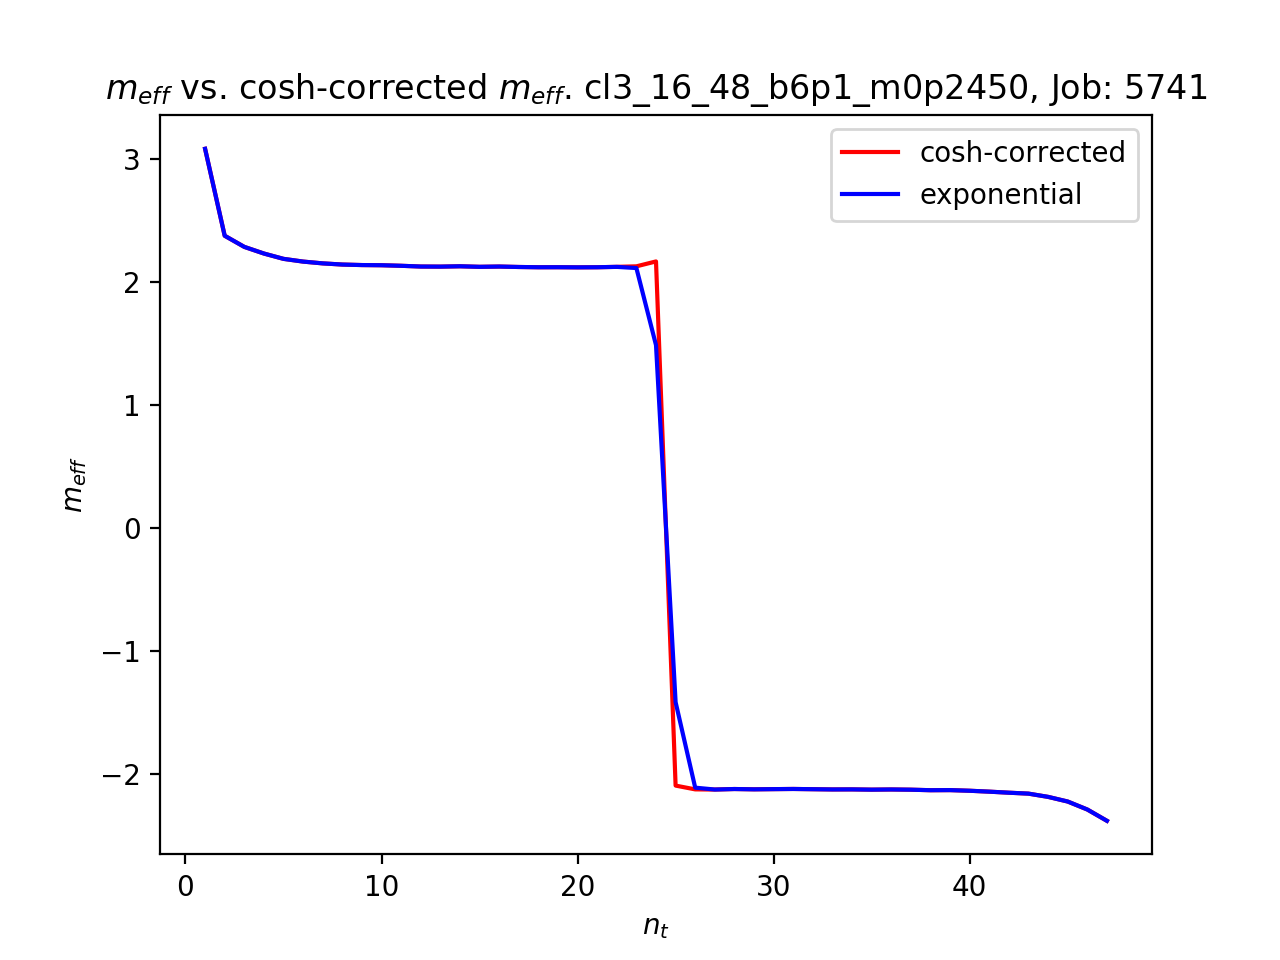

In [10]:
plt.figure()
plt.plot(range(1, n_t), μ_cosh, 'r', label = 'cosh-corrected')
plt.plot(range(1, n_t), μ_m_eff, 'b', label = 'exponential')

plt.title('$m_{eff}$ vs. cosh-corrected $m_{eff}$. ' + cfgbase + ', Job: ' + str(job_num))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')
plt.legend()

plt.show()

In [11]:
if save_graphs:
    plt.savefig('/Users/theoares/lqcd/pion_mass/output/graphs/1_22_2020/' + cfgbase + '/meff_cosh_' + str(job_num) + '.png')

## Determine effective mass

In [12]:
fit_region = np.arange(15, 35)
μ_cosh_flipped = analysis.flip_half_data(μ_cosh, n_t)
m_eff = analysis.extract_mass(fit_region, μ_cosh_flipped)
m_plot = np.ones(n_t - 1) * m_eff
print('Effective mass is: ' + str(m_eff))

Effective mass is: 2.123711010169403


<IPython.core.display.Javascript object>


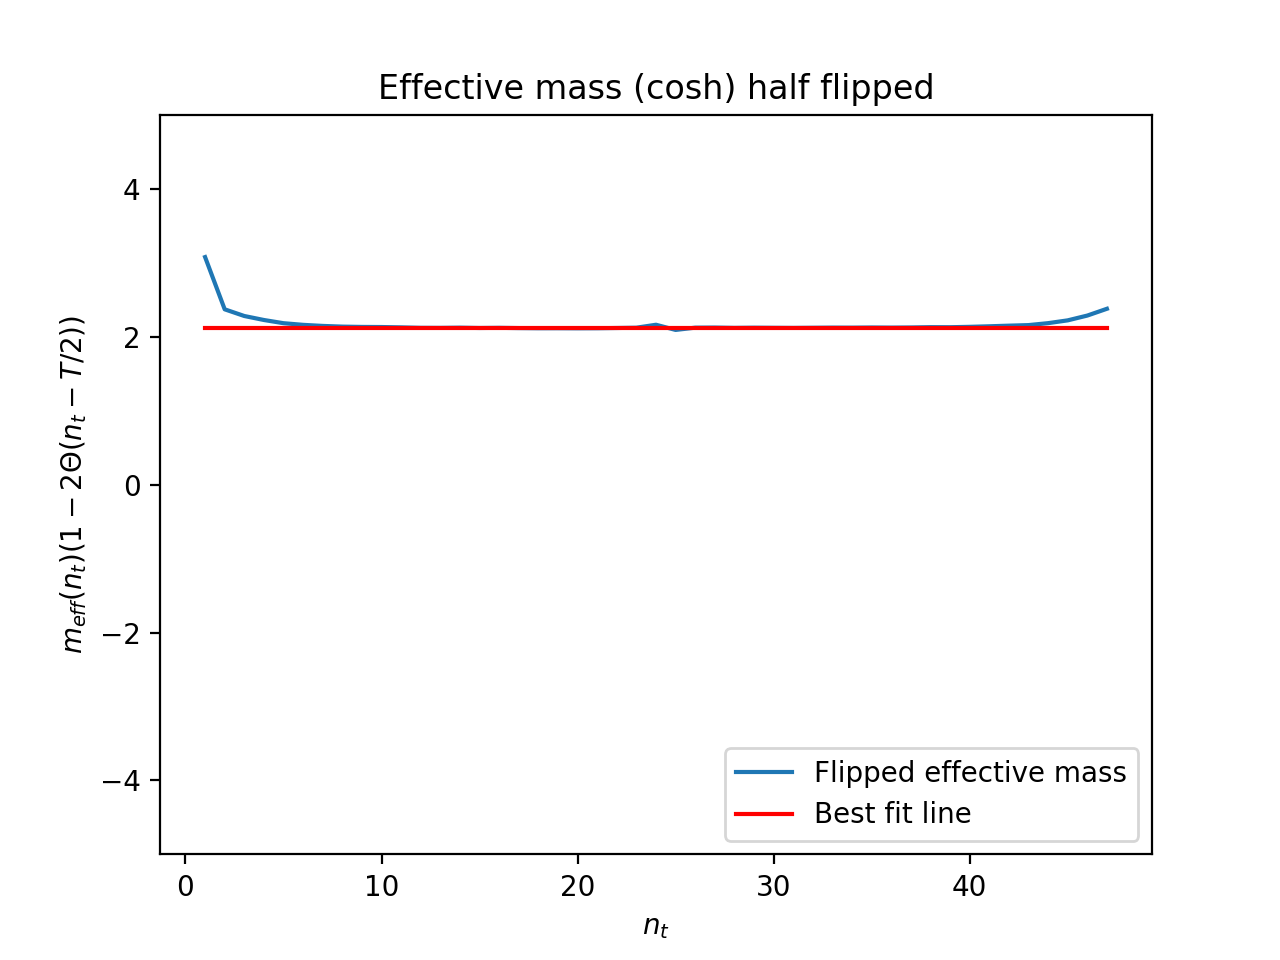

In [13]:
plt.figure()
plt.plot(range(1, n_t), μ_cosh_flipped, label = 'Flipped effective mass')
plt.plot(range(1, n_t), m_plot, color = 'r', label = 'Best fit line')
plt.title('Effective mass (cosh) half flipped')
plt.ylim((-5, 5))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}(n_t)(1 - 2Θ(n_t - T / 2))$')
plt.legend(loc = 'lower right')

## Determine error scaling

In [14]:
base_time = 15
cfg_list, err, means = analysis.error_analysis(C, base_time, 10, 10)

<IPython.core.display.Javascript object>


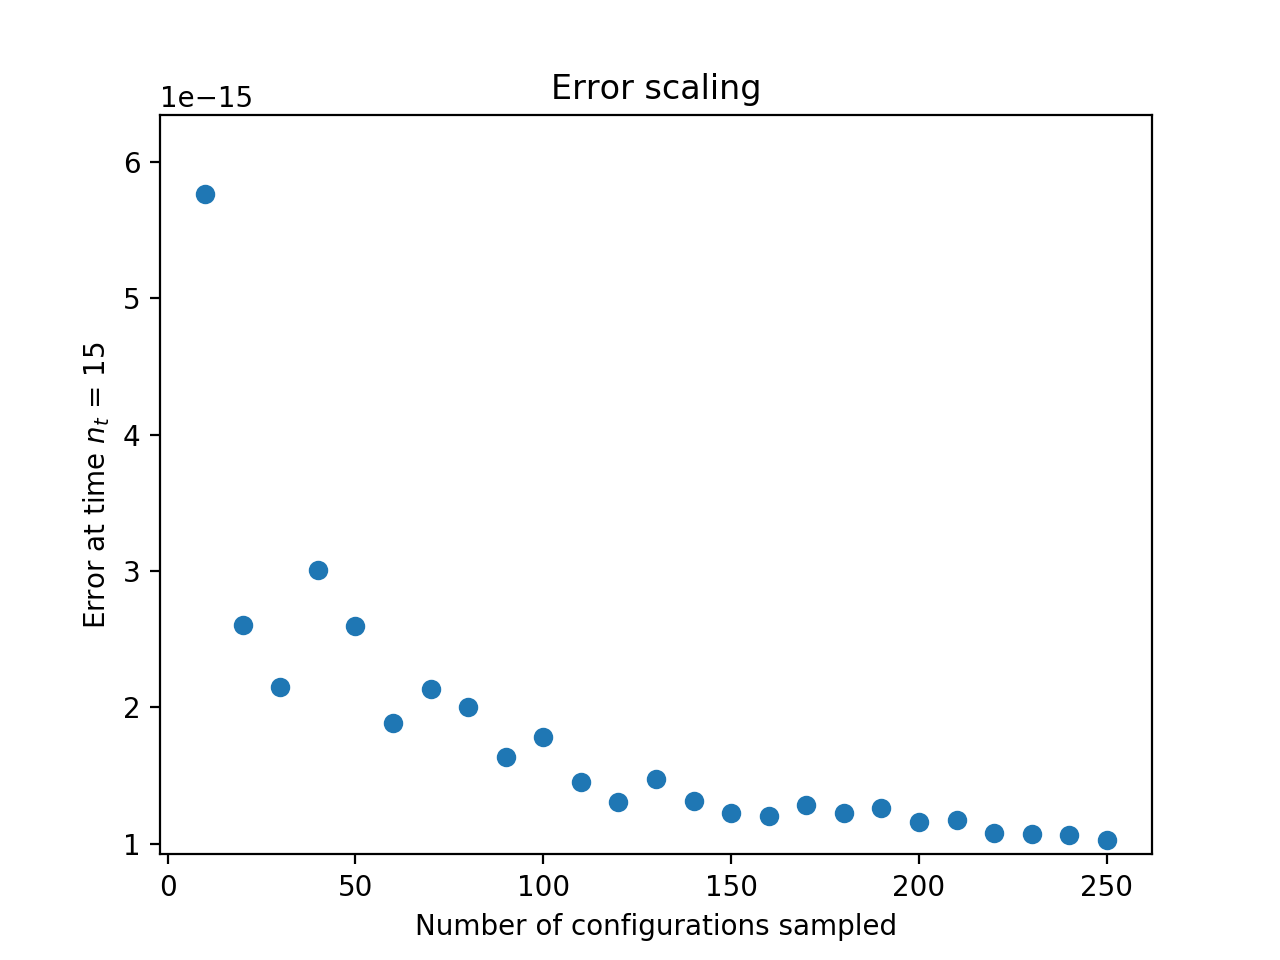

In [15]:
plt.figure()
plt.scatter(cfg_list, err)
plt.title('Error scaling')
plt.xlabel('Number of configurations sampled')
plt.ylabel('Error at time $n_t$ = ' + str(base_time))
# plt.ylim((1e-18, 1e-17))
plt.ylim((.9 * np.min(err), 1.1 * np.max(err)))
plt.show()